
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.


# Projet final : Débordement d'égouts
### Équipe 17 : Elie Rouphael, Souhaila Mellouk, Thien-Kim Luu, Mourad Younes, Chararbsissy Lynn
Remis le vendredi 20 décembre

# Introduction

Le but de ce projet consiste à déterminer les caractéristiques des événements pluvieux susceptibles de générer des surverses sur le territoire de la Ville de Montréal. Il s'agit d'établir le lien entre les événements pluvieux et les surverses dues aux précipitations. On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

In [940]:
using Distributions

In [941]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Missings

ArgumentError: ArgumentError: Package Missings not found in current path:
- Run `import Pkg; Pkg.add("Missings")` to install the Missings package.


# Chargement des données et nettoyage préliminaire

## Chargement des surverses

In [942]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


## Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [943]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,0642-01D,2013-05-01,0,missing
2,0642-01D,2013-05-02,0,missing
3,0642-01D,2013-05-03,0,missing
4,0642-01D,2013-05-04,0,missing
5,0642-01D,2013-05-05,0,missing


#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [944]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String
1,0642-01D,2013-05-01,0,Inconnue
2,0642-01D,2013-05-02,0,Inconnue
3,0642-01D,2013-05-03,0,Inconnue
4,0642-01D,2013-05-04,0,Inconnue
5,0642-01D,2013-05-05,0,Inconnue


#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [945]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])

,NO_OUVRAGE,DATE,SURVERSE
,String,Date,Int64⍰
1,0642-01D,2013-05-01,0
2,0642-01D,2013-05-02,0
3,0642-01D,2013-05-03,0
4,0642-01D,2013-05-04,0
5,0642-01D,2013-05-05,0
6,0642-01D,2013-05-06,0
7,0642-01D,2013-05-07,0
8,0642-01D,2013-05-08,0
9,0642-01D,2013-05-09,0


#### Exclusion des lignes où :SURVERSE est manquante

In [946]:
surverse_df = dropmissing(data, disallowmissing=true);

In [947]:
n₁ = sum(x->x==1, surverse_df[:SURVERSE], dims=1) 
n₀ = sum(x->x==0, surverse_df[:SURVERSE], dims=1) 
n = n₀ + n₁

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[947]:1
└ @ Core In[947]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[947]:2
└ @ Core In[947]:2


1-element Array{Int64,1}:
 161098

In [948]:
filtervals = ["3260-01D"; "3350-07D"; "4240-01D"; "4350-01D"; "4380-01D"]
surverse_df1 = filter(row-> row.NO_OUVRAGE == filtervals[1], surverse_df)
surverse_df2 = filter(row-> row.NO_OUVRAGE == filtervals[2], surverse_df)
surverse_df3 = filter(row-> row.NO_OUVRAGE == filtervals[3], surverse_df)
surverse_df4 = filter(row-> row.NO_OUVRAGE == filtervals[4], surverse_df)
surverse_df5 = filter(row-> row.NO_OUVRAGE == filtervals[5], surverse_df);

In [949]:
#### on prend pour chaque ouvrage le nombre de fois ou il a eu surver et non
n₁ = Int64[]
n₀  = Int64[]
n  = Int64[]

0-element Array{Int64,1}

In [950]:

function findSurverseCount(surverse_df1)
    n1₁ = sum(x->x==1, surverse_df1, dims=1) 
    push!(n₁, n1₁[1])
    n1₀ = sum(x->x==0, surverse_df1, dims=1)  
    push!(n₀, n1₀[1])
    n1= n1₁[1] + n1₀[1]
    push!(n, n1)
end

findSurverseCount (generic function with 1 method)

In [951]:
findSurverseCount(surverse_df1[:SURVERSE]);
findSurverseCount(surverse_df2[:SURVERSE]);
findSurverseCount(surverse_df3[:SURVERSE]);
findSurverseCount(surverse_df4[:SURVERSE]);
findSurverseCount(surverse_df5[:SURVERSE]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[951]:1
└ @ Core In[951]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[951]:2
└ @ Core In[951]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[951]:3
└ @ Core In[951]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[951]:4
└ @ Core In[951]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[951]:5
└ @ Core In[951]:5


## Chargement des précipitations

In [952]:
databefore = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(databefore, Symbol("St-Hubert")=>:StHubert)
first(databefore,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


In [953]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)
first(data,5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2013-01-01,0,0,0,0,0,missing
2,2013-01-01,1,0,0,0,0,missing
3,2013-01-01,2,0,0,0,0,missing
4,2013-01-01,3,0,0,0,0,missing
5,2013-01-01,4,0,0,0,0,missing


## Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

Nous avons extracté dans "data" toutes les données venant du moi de mai jusqu'au moi d'octobre. Nous avons aussi crée une
variable "databefore", qui va surtout servir pour les jours ou il n'a pas plu mais il y'a eu quand meme une surverse. Nous 
avons choisis d'extracter à partir du mois d'avril, puisqu'il existe quand même la possibilité que le premier mai, il y'a 
surverse, même s'il n'a pas plu, et dans ce cas il faudra vérifier le jour précédent, soit le 30 Avril.

In [954]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
databefore = filter(row -> month(row.date) > 3, databefore) b
databefore = filter(row -> month(row.date) < 11, databefore) 
databefore = filter(row -> row.heure >= 19, databefore) ;

LoadError: syntax: extra token "b" after end of expression

fillWithMean() va principalement s'occuper à remplacer tous les missing values par la moyenne des autres colonnes de 
précipitation. Dans le cas ou toutes les valeurs d'une date spécifique sont égales a missing, elle va les remplacer 
par un zéro.

In [955]:
function fillWithMean(table)
    
    for j=1:size(table,1)
        means = 0
        sum = 0
        alo = names(table)
        for col in alo
            if col != alo[1]
                if !ismissing(table[j, col]) 
                    sum = sum +1
                    means = means + table[j, col]
                end
            end
        end
        if sum != 0
            means = means / sum
        end
        for col in alo
            if ismissing(table[j, col]) && col != alo[1]
                tests = floor(means)
                table[j, col] = floor(tests)
            end
        end
    end
end

fillWithMean (generic function with 1 method)

In [956]:
fillWithMean(data)
fillWithMean(databefore)

ArgumentError: ArgumentError: CSV.Column is read-only; to get a mutable vector, do `copy(col)` or to make all columns mutable do `CSV.read(file; copycols=true)` or `CSV.File(file) |> DataFrame`

In [957]:
pcp_sum = by(data, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum);
first(pcp_sum ,5);

In [958]:
pcp_max = by(data, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5);

In [959]:
pcp_sumBefore = by(databefore, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum);
first(pcp_sum ,5);

In [960]:
pcp_maxBefore = by(databefore, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5);

# Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de voir s'il existe un lien entre les précipitations et les surverses.

Prenons arbitrairement l'ouvrage de débordement près du Bota-Bota (4350-01D). La station météorologique la plus proche est McTavish. Prenons deux variables explicatives simple :
- la somme journalière des précipitations
- le taux horaire maximum journalier de précipitations

#### Calcul de la quantité journalière de précipitations pour chacune des stations météorologiques

**findMeanOfAllColumn** mets dans une colonne toutes les colonnes de la table passée en paramètres

@params une table 

@return une table

In [961]:
function findMeanOfAllColumn(table)
    p = DataFrame(name =Float64[])
    for j=1:size(table,1)
        alo = names(table)
        means = 0
        sum = 0
        for col in alo
            if col != alo[1]
                if !ismissing(table[j, col]) 
                    sum = sum +1
                    means = means + table[j, col]
                end
            end
        end
        push!(p, means/sum)
    end
    table = DataFrame(date = table[:date]; name =p[:name]);
    return table
end

findMeanOfAllColumn (generic function with 1 method)

In [962]:
CSV.write("pcp_max_before.csv",pcp_max)
CSV.write("pcp_sum_before.csv",pcp_sum)

"pcp_sum_before.csv"

#### Inclusion dans un dataframe de ces deux variables explicatives potentielles

**Tableau 1. Distances entre les stations pluviométriques et les lieux des ouvrages**

|  | McTavish | Ste-Anne-de-Bellevue | Montréal/Pierre Elliott Trudeau Intl | Montréal/St-Hubert | L’Assomption |
|----------|----------|----------|----------|----------|----------|
| Rivière-des-Prairies | 16,56 km | 37,31 km | 24,05 km | 19,91 km | 20,98 km 
| Ahunstic | 10,00 km | 23,21 km | 9,69 km | 21,68 km | 35,44 km |
| Pointe-aux-Trembles | 17,67 km | 42,82 km | 28,37 km | 15,68 km | 18.19 km |
| Vieux-Montréal | 2,16 km | 30,66 km | 15,18 km | 10,74 km | 35,60 km |
| Verdun | 4,29 km | 29,58 km | 14,45 km | 12,10 km | 38,95 km |


Ces distances ont été trouvé à l'aide de Google Map.

**calculateMeanUsingDistance** mets dans une table la moyenne des surverses des stations les plus proches en fonction des ouvragres

@params une table (ex: pcp_sum, pcp_max ...) 

@return une table

In [963]:
function calculateMeanUsingDistance(table)
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :StHubert], Assomption=table[:, :Assomption]);
    S4240 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :StHubert], Assomption=table[:, :Assomption]);
    S3260 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish]);
    S4350_4380 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :Trudeau]);
    S3350 = findMeanOfAllColumn(p);
    
    return DataFrame(date = table[:, :date],S4240=S4240[:name], S3260=S3260[:name],S4350_4380=S4350_4380[:name],S3350=S3350[:name] );
end

calculateMeanUsingDistance (generic function with 1 method)

In [964]:
pcp_sum = calculateMeanUsingDistance(pcp_sum)
pcp_max = calculateMeanUsingDistance(pcp_max)
pcp_sumBefore = calculateMeanUsingDistance(pcp_sumBefore)
pcp_maxBefore = calculateMeanUsingDistance(pcp_maxBefore)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = findMeanOfAllColumn(::DataFrame) at In[961]:17
└ @ Main .\In[961]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = findMeanOfAllColumn(::DataFrame) at In[961]:17
└ @ Main .\In[961]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[963]:11
└ @ Main .\In[963]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[963]:11
└ @ Main .\In[963]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[963]:11
└ @ Main .\In[963]:11
┌ Warning: `getindex(df::DataFrame, col_ind::Colu

,date,S4240,S3260,S4350_4380,S3350
,Date,Float64,Float64,Float64,Float64
1,2013-01-01,0.0,0.0,0.0,0.0
2,2013-01-02,0.0,0.0,0.0,0.0
3,2013-01-03,0.0,0.0,0.0,0.0
4,2013-01-04,16.5,16.5,13.0,9.0
5,2013-01-05,0.0,0.0,0.0,0.0
6,2013-01-06,11.0,11.0,12.0,8.5
7,2013-01-07,0.0,0.0,0.0,0.0
8,2013-01-08,0.0,0.0,0.0,0.0
9,2013-01-09,16.0,16.0,12.0,6.0


In [965]:
filtervals = ["3260-01D"; "3350-07D"; "4240-01D"; "4350-01D"; "4380-01D"];
table = ["S3260", "S3350","S4240","S4350_4380", "S4350_4380"];

In [966]:
moyenneSumSurverses = Float64[]
moyenneMaxSurverses = Float64[]
varianceSumSurverses = Float64[];
varianceMaxSurverses = Float64[];

moyenneSumNonSurverses = Float64[]
moyenneMaxNonSurverses = Float64[]
varianceSumNonSurverses = Float64[]
varianceMaxNonSurverses = Float64[]
for j=1:size(filtervals,1)
    dfSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j]  && row.SURVERSE ==1, surverse_df)
    dfNonSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j]  && row.SURVERSE ==0, surverse_df)


    moyenneSumSurverse = 0;
    moyenneMaxSurverse = 0;
    for i=1:size(dfSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        moyenneSumSurverse += pcp_sum[ind,Symbol(table[j])]
        
        indmax = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        moyenneMaxSurverse +=  pcp_max[indmax,Symbol(table[j])]
    end
    moyenneSumSurverse = moyenneSumSurverse / size(dfSurverse,1)
    push!(moyenneSumSurverses, moyenneSumSurverse)
    moyenneMaxSurverse = moyenneMaxSurverse / size(dfSurverse,1)
    push!(moyenneMaxSurverses, moyenneMaxSurverse)
    
    moyenneSumNonSurverse = 0;
    moyenneMaxNonSurverse = 0;
    for i=1:size(dfNonSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfNonSurverse[i,:DATE])
        moyenneSumNonSurverse = moyenneSumNonSurverse +  pcp_sum[ind,Symbol(table[j])]
        
        ind = findfirst(pcp_max[:,:date] .== dfNonSurverse[i,:DATE])
        moyenneMaxNonSurverse = moyenneMaxNonSurverse +  pcp_max[ind,Symbol(table[j])]
    end
    moyenneSumNonSurverse /= size(dfNonSurverse,1)
    push!(moyenneSumNonSurverses, moyenneSumNonSurverse)
    moyenneMaxNonSurverse /= size(dfNonSurverse,1)
    push!(moyenneMaxNonSurverses, moyenneMaxNonSurverse)
    
    
    
    #### maintenant la variance
    varianceSumSurverse = 0;
    varianceMaxSurverse = 0;
    for i=1:size(dfSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        varianceSumSurverse += (pcp_sum[ind,Symbol(table[j])]-moyenneSumSurverse)^2

        ind = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        varianceMaxSurverse += (pcp_max[ind,Symbol(table[j])]-moyenneMaxSurverse)^2
        
       
    end
    varianceSumSurverse /= size(dfSurverse,1)
    push!(varianceSumSurverses, varianceSumSurverse)
    varianceMaxSurverse /= size(dfSurverse,1)
    push!(varianceMaxSurverses, varianceMaxSurverse)

    
    varianceSumNonSurverse = 0;
    varianceMaxNonSurverse = 0;
    for i=1:size(dfNonSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfNonSurverse[i,:DATE])
        varianceSumNonSurverse += (pcp_sum[ind,Symbol(table[j])]-moyenneSumNonSurverse)^2

        ind = findfirst(pcp_max[:,:date] .== dfNonSurverse[i,:DATE])
        varianceMaxNonSurverse += (pcp_max[ind,Symbol(table[j])]-moyenneMaxNonSurverse)^2
    
    end
    varianceSumNonSurverse /= size(dfNonSurverse,1)
    push!(varianceSumNonSurverses, varianceSumNonSurverse)
    varianceMaxNonSurverse /= size(dfNonSurverse,1)
    push!(varianceMaxNonSurverses, varianceMaxNonSurverse) 
end


#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que la somme des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

#### Traçage des distribution de la somme des précipitations en fonction des surverses ou non

On remarque que les deux distributions sont très différentes. Ceci suggère que le maximum journalier des précipitations à la station McTavish a un effet sur les surverses au Bota-Bota.

# Création du fichier de prédictions pour soumettre sur Kaggle

Dans ce cas-ci, nous prédirons une surverse avec une probabilité de 1/2 sans considérer aucune variable explicative.

In [967]:

testfile = CSV.read("data/test.csv")
first(testfile,5)

,NO_OUVRAGE,DATE
,String,Date
1,3260-01D,2019-05-02
2,3260-01D,2019-05-09
3,3260-01D,2019-05-10
4,3260-01D,2019-05-15
5,3260-01D,2019-05-20


In [968]:

#indx = findfirst(pcp_sumBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
# sumBefore= pcp_sumBefore[indx,Symbol(table[indproba])]

#indx = findfirst(pcp_maxBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
#maxBefore = pcp_maxBefore[indx,Symbol(table[indproba])]
#     
#pSumBeforeSurverses = (1/sqrt(2*π*varianceSumBeforeSurverses[indproba])) - (1/2)*(((sumBefore-moyenneSumBeforeSurverses[indproba])^2)/varianceSumBeforeSurverses[indproba])
 pSumBeforeSurverses = (1/sqrt(2*π*varianceSumBeforeSurverses[indproba]))*exp(- (1/2)*(((sumBefore-moyenneSumBeforeSurverses[indproba])^2)/varianceSumBeforeSurverses[indproba]))

pMaxBeforeSurverses = (1/sqrt(2*π*varianceMaxBeforeSurverses[indproba]))*exp(- (1/2)*(((maxBefore-moyenneMaxBeforeSurverses[indproba])^2)/varianceMaxBeforeSurverses[indproba]))
  

#pMaxBeforeSurverses = (1/sqrt(2*π*varianceMaxBeforeSurverses[indproba])) - (1/2)*(((maxBefore-moyenneMaxBeforeSurverses[indproba])^2)/varianceMaxBeforeSurverses[indproba])
     

UndefVarError: UndefVarError: varianceSumBeforeSurverses not defined

In [969]:
surverse = Int[]
for i=1:size(testfile,1)
    indproba = findfirst(filtervals[:] .== testfile[i,:NO_OUVRAGE])
    ind = findfirst(pcp_sum[:,:date] .== testfile[i,:DATE])
    sum = pcp_sum[ind,Symbol(table[indproba])]
    ind = findfirst(pcp_max[:,:date] .== testfile[i,:DATE])
    max = pcp_max[ind,Symbol(table[indproba])]
      
    indx = findfirst(pcp_sumBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
    sumBefore= pcp_sumBefore[indx,Symbol(table[indproba])]

    indx = findfirst(pcp_maxBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
    maxBefore = pcp_maxBefore[indx,Symbol(table[indproba])]
    Psurverse = n₁[indproba]/n[indproba]

    pSumSurverses = (1/sqrt(2*π*varianceSumSurverses[indproba])) *exp(- (1/2)*(((sum-moyenneSumSurverses[indproba])^2)/varianceSumSurverses[indproba]))

    pMaxSurverses = (1/sqrt(2*π*varianceMaxSurverses[indproba]))*exp(- (1/2)*(((max-moyenneMaxSurverses[indproba])^2)/varianceMaxSurverses[indproba]))
    
    Pnonsurverse = n₀[indproba]/n[indproba]

    pSumNonSurverses = (1/sqrt(2*π*varianceSumNonSurverses[indproba]))*exp(- (1/2)*(((sum-moyenneSumNonSurverses[indproba])^2)/varianceSumNonSurverses[indproba]))
    pMaxNonSurverses = (1/sqrt(2*π*varianceMaxNonSurverses[indproba]))*exp(- (1/2)*(((max-moyenneMaxNonSurverses[indproba])^2)/varianceMaxNonSurverses[indproba]))
  
    pxSsurverse = pSumSurverses * pMaxSurverses
    
    pxSnonsurverse = pSumNonSurverses * pMaxNonSurverses
    
  
    psurverse = (pxSsurverse * Psurverse)/(pxSsurverse * Psurverse + pxSnonsurverse*Pnonsurverse)
    isSurverse = psurverse>0.5
    
    #if isSurverse == 1
        push!(surverse, isSurverse);
   # else
    #     pxSsurverse = pSumSurverses * pMaxSurverses *pSumBeforeSurverses
    
    #    pxSnonsurverse = pSumNonSurverses * pMaxNonSurverses * pSumBeforeNonSurverses
    
  
    #    psurverse = (pxSsurverse * Psurverse)/(pxSsurverse * Psurverse + pxSnonsurverse*Pnonsurverse)
    #    isSurverse = psurverse>0.5 && sumBefore!=0 && sum !=0
    #    push!(surverse, isSurverse);
    #end
end
# Pour chacune des lignes du fichier test, comportant un ouvrage et une date, une prédiction est requise.
# Dans ce cas-ci, utilisons une prédiction les plus naîve. 
# On prédit avec une chance sur deux qu'il y ait surverse, sans utiliser de variables explicatives



# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = testfile[:,:NO_OUVRAGE].*"_".*string.(testfile[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=surverse)
CSV.write("result.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.


"result.csv"

In [986]:
for j=1:size(filtervals,1)
    dfSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j] , surverse_df)
    sums = DataFrame(SUM =Float64[])
    maxs = DataFrame(MAX =Float64[])
    surverse = DataFrame(surverse =Int64[])
    for i=1:size(dfSurverse,1)
        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        push!(sums, pcp_sum[ind,Symbol(table[j])])

        indmax = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        push!(maxs, pcp_max[indmax, Symbol(table[j])])

        push!(surverse, dfSurverse[i,:SURVERSE])
        
    end
    if j.==1
        table1 = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse])
    elseif j.==2
        table2 = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse])
    elseif j.==3
        lol = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse])
    elseif j.==4
        lol1 = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse])
    elseif j.==5
        lol2 = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse])
    end
end
lol

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[986]:17
└ @ Core In[986]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[986]:17
└ @ Core In[986]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[986]:17
└ @ Core In[986]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[986]:19
└ @ Core In[986]:19
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[986]:19
└ @ Core In[986]:19
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[986]:19
└ @ Core In[986]:1

,SUM,MAX,SURVERSE
,Float64,Float64,Int64
1,15.3333,1.33333,0
2,15.3333,1.33333,0
3,15.3333,1.33333,0
4,15.3333,1.33333,0
5,15.3333,1.33333,0
6,15.3333,1.33333,0
7,15.3333,1.33333,0
8,15.3333,1.33333,0
9,27.0,11.6667,0


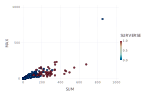

In [971]:
plot(table1, x="SUM", y="MAX",color="SURVERSE",  Geom.point)

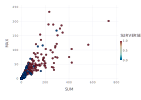

In [972]:
plot(table2, x="SUM", y="MAX",color="SURVERSE",  Geom.point)

In [973]:
plot(table3, x="SUM", y="MAX",color="SURVERSE",  Geom.point)

UndefVarError: UndefVarError: table3 not defined

In [974]:
plot(table4, x="SUM", y="MAX",color="SURVERSE",  Geom.point)

UndefVarError: UndefVarError: table4 not defined

In [975]:
plot(table5, x="SUM", y="MAX",color="SURVERSE",  Geom.point)

UndefVarError: UndefVarError: table5 not defined